<a href="https://colab.research.google.com/github/salmanbhatti87/CodeSoft/blob/main/Resnet50_with_98_percent_accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import os
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

In [2]:
# Download and extract the dataset
dataset_url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
dataset_path = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=dataset_url, extract=True)
dataset_dir = os.path.join(os.path.dirname(dataset_path), 'cats_and_dogs_filtered')
train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'validation')

68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [3]:
import tensorflow as tf
import os

dataset_url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
path_to_zip = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=dataset_url, extract=True)

dataset_dir = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

# Verify dataset structure
print("Dataset directory exists:", os.path.exists(dataset_dir))
print("Subdirectories:", os.listdir(dataset_dir) if os.path.exists(dataset_dir) else "Not found")

train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'validation')

print("Train directory exists:", os.path.exists(train_dir))
print("Validation directory exists:", os.path.exists(val_dir))

Dataset directory exists: False
Subdirectories: Not found
Train directory exists: False
Validation directory exists: False


In [4]:
import os
import tensorflow as tf

# Get the default storage path for datasets
dataset_path = tf.keras.utils.get_file(
    'cats_and_dogs_filtered.zip',
    origin="https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
)

print("Downloaded file path:", dataset_path)

Downloaded file path: /root/.keras/datasets/cats_and_dogs_filtered.zip


In [5]:
import zipfile
import os

# Path to the downloaded ZIP file
dataset_zip_path = "/root/.keras/datasets/cats_and_dogs_filtered.zip"

# Extract it in the same directory
extract_path = os.path.dirname(dataset_zip_path)

with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verify extraction
extracted_dir = os.path.join(extract_path, "cats_and_dogs_filtered")
print("Dataset directory exists:", os.path.exists(extracted_dir))
print("Contents:", os.listdir(extracted_dir) if os.path.exists(extracted_dir) else "Extraction failed")

Dataset directory exists: True
Contents: ['train', 'validation', 'vectorize.py']


In [6]:
from tensorflow.keras.applications.resnet50 import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


In [8]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Important for metrics
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [9]:
import numpy as np
labels = train_data.classes
np.bincount(labels)

array([1000, 1000])

In [10]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)

class_weights_dict = dict(enumerate(class_weights))

In [11]:
# Load ResNet50 without top classification layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [12]:
# Freeze all layers first
for layer in base_model.layers:
    layer.trainable = False

In [13]:
# Unfreeze last 50 layers
for layer in base_model.layers[-50:]:
    layer.trainable = True

In [14]:
# Build the final model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

In [15]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
# Show model summary (optional)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 17,212,929 (65.66 MB)

 Non-trainable params: 6,637,184 (25.32 MB)

In [17]:
# Train the model
history = model.fit(
    train_data,
    epochs=30,                      # you can change this number
    validation_data=validation_data,
    steps_per_epoch=len(train_data),
    validation_steps=len(validation_data),
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 80s 788ms/step - accuracy: 0.9045 - loss: 0.2187 - val_accuracy: 0.9260 - val_loss: 18.1437
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 49s 483ms/step - accuracy: 0.9613 - loss: 0.0853 - val_accuracy: 0.9800 - val_loss: 0.3372
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 496ms/step - accuracy: 0.9796 - loss: 0.0551 - val_accuracy: 0.9840 - val_loss: 0.2399
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 478ms/step - accuracy: 0.9718 - loss: 0.0839 - val_accuracy: 0.9810 - val_loss: 0.1150
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 493ms/step - accuracy: 0.9769 - loss: 0.0681 - val_accuracy: 0.9760 - val_loss: 0.1244
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 482ms/step - accuracy: 0.9832 - loss: 0.0539 - val_accuracy: 0.9640 - val_loss: 0.1448
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 491ms/step - accuracy: 0.9816 - loss: 0.0457 - val_accuracy: 0.9310 - val_loss: 0.6012
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 494ms/step - accuracy: 0.9820 - loss: 0.0458 - val_acc

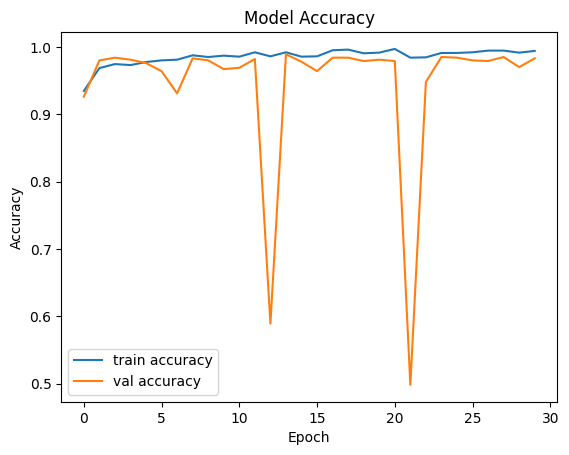

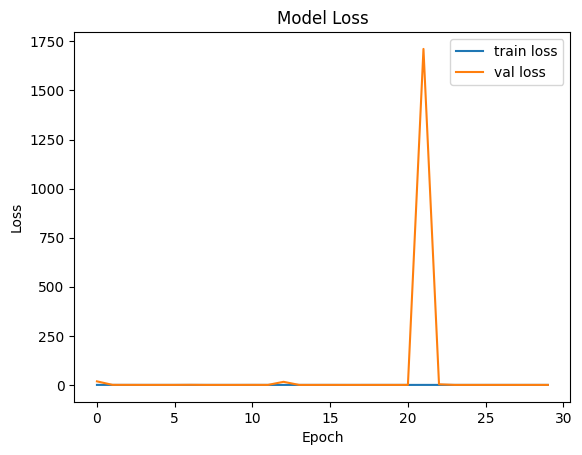

In [18]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [20]:
# Get predictions from the model
Y_pred = model.predict(validation_data)
y_pred = (Y_pred > 0.5).astype("int32")  # Convert probabilities to binary class labels

# Get true labels
y_true = validation_data.classes

32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 233ms/step


In [21]:
# Classification Report
print("Classification Report:")
target_names = list(validation_data.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=target_names))

# Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

Classification Report:
              precision    recall  f1-score   support

        cats       0.99      0.97      0.98       500
        dogs       0.97      0.99      0.98       500

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000

Confusion Matrix:
[[486  14]
 [  3 497]]


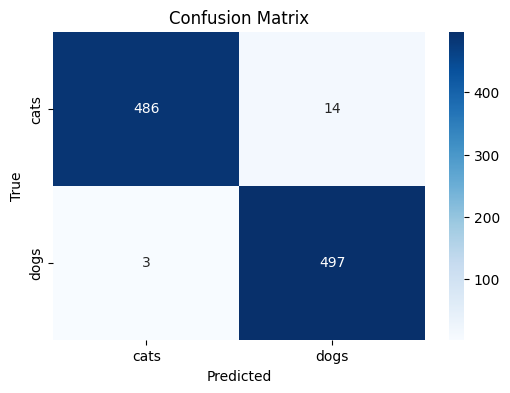

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()